# Climate indices

Calculate some indices of climate variability. 
* ENSO: https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
* PDO: Mantua and Hare (2002), https://doi.org/10.1023/A:1015820616384
* AMO: Nigam et al. (2018), 10.1175/JCLI-D-17-0010.1

Author: Joakim Kjellsson (with help from Leon Chafik)

In [267]:
import numpy as np
import xarray as xr
import scipy as sp
from scipy.signal import detrend
from scipy.stats import linregress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from eofs.xarray import Eof

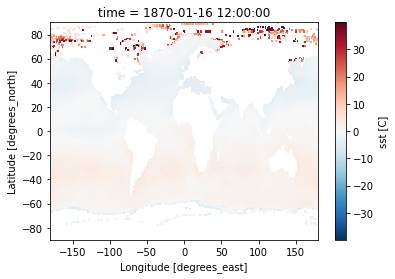

In [268]:
ds_had = xr.open_dataset('/data/user/jkjellsson/HadISST_sst_detrend.nc',use_cftime=True)
hadsst = ds_had['sst'].where(ds_had['sst'] > -5).where(ds_had['sst'] < 40).rename({'longitude':'lon', 'latitude':'lat'})
hadsst.isel(time=0).plot()

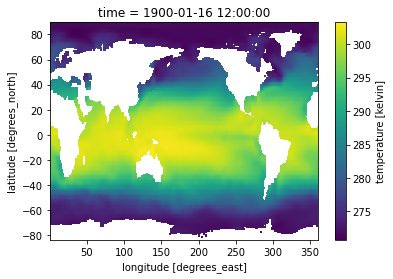

In [269]:
ds_en = xr.open_dataset('/data/user/jkjellsson/en4/analysis/EN.4.2.1.f.analysis.g10.1900-2018_sfc.nc',use_cftime=True).rename({'temperature':'sst'}).isel(depth=0).drop('depth')
ensst = ds_en['sst']
ensst.isel(time=0).plot()

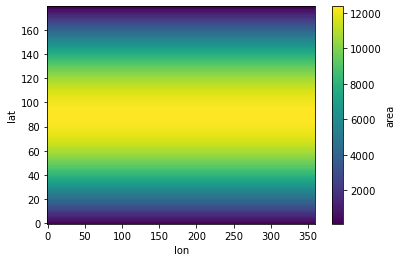

In [270]:
area = np.zeros((hadsst.shape[1],hadsst.shape[2]))
radius = 6371e3
for jj in range(0,area.shape[0]):
    dx = 1. * np.pi/180. * radius * np.cos(hadsst['lat'][jj] * np.pi/180.)
    dy = 1. * np.pi/180. * radius
    area[jj,:] = dx * dy
ds_had['area'] = (('lat','lon'), area)
(ds_had['area']/1e6).plot()

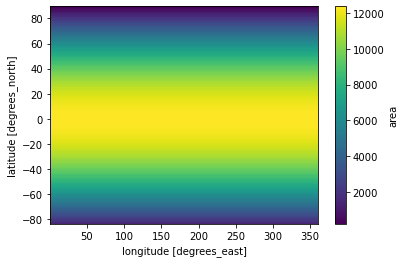

In [271]:
area = np.zeros((ensst.shape[1],ensst.shape[2]))
for jj in range(0,area.shape[0]):
    dx = 1. * np.pi/180. * radius * np.cos(ensst['lat'][jj] * np.pi/180.)
    dy = 1. * np.pi/180. * radius
    area[jj,:] = dx * dy
ds_en['area'] = (('lat','lon'), area)
(ds_en['area']/1e6).plot()

## Climate indices

### ENSO (NINO3)
* Detrended
* Monthly anomalies
* Averaged over 150W - 90W, 5S-5N. 
* 3-month running mean

### PDO
* Detrended
* Monthly anomalies
* Removed global-mean SST anomaly
* EOF1 over 20N - 60N, 120E-100W

### AMO
* Detrended
* Monthly anomalies
* EOF1 from 1950-present (EN4)
* Or compare 1993-2004 vs 2005-2016

In [272]:
def lin_regress(x, y):
    reg_slope, _, _, _, _ = linregress(x, y)
    return reg_slope

def shift_lon(ds,lonname='lon',shift360=False):
    if shift360:
        # Search for prime meridian
        lon = ds['lon'].values
        lon180 = np.where(lon >= 180)[0].min() + 1
        # Roll longitudes
        ds_180 = ds.roll(lon=lon180, roll_coords=True)
        lon = ds_180['lon'].values
        # Remove lon
        ds_180.drop('lon')
        # Convert lon
        lon = np.where( lon > 180, lon-360, lon)
        # Replace
        ds_180['lon'] = lon
    else:
        # Search for prime meridian
        lon = ds['lon'].values
        lon0 = np.where(lon < 0)[0].max() + 1
        # Roll longitudes
        ds_180 = ds.roll(lon=lon0, roll_coords=True)
        lon = ds_180['lon'].values
        # Remove lon
        ds_180.drop('lon')
        # Convert lon
        lon = np.where( lon < 0, lon+360, lon)
        # Replace
        ds_180['lon'] = lon
    
    return ds_180

def enso(ds):
    """
    """
    sst = ds['sst']
    area = ds['area']
    sst_anom = sst.groupby('time.month') - sst.groupby('time.month').mean('time')
    sst_nino = sst_anom.sel(lon=slice(210,270),lat=slice(-5,5))
    area_nino = area.sel(lon=slice(210,270),lat=slice(-5,5))
    nino = (sst_nino * area_nino).sum(('lon','lat')) / area_nino.sum(('lon','lat'))
    nino_run = nino.rolling(time=5,center=True).mean()
    
    slope = xr.apply_ufunc(lin_regress,
                           nino_run[3:-3], sst_anom[3:-3],
                           vectorize = True, dask = 'parallelized',
                           input_core_dims = [['time'], ['time']],
                           output_dtypes = ['d']).compute()
    
    fig, axs = plt.subplots(1,2,figsize=(15,6))
    nino_run.plot(ax=axs[0])
    slope.plot.pcolormesh(ax=axs[1])
    
    return nino_run, slope

def pdo(ds,plot=False):
    sst = ds['sst']
    area = ds['area']
    # remove monthly climatology
    sst_anom = sst.groupby('time.month') - sst.groupby('time.month').mean('time')
    # compute global-mean sst anom
    sst_mean_anom = (sst_anom * area).sum(('lon','lat')) / area.sum(('lon','lat'))
    # remove global-mean sst anom
    sst_pdo = (sst_anom - sst_mean_anom)
    # select Pacific Ocean 20N-60N
    sst_pdo_pac = sst_pdo.sel(lat=slice(20,60),lon=slice(120,260))
    
    # Compute EOFs
    coslat = np.cos(np.deg2rad(sst_pdo_pac.coords['lat'].values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(sst_pdo_pac, weights=wgts)
    eofs = solver.eofsAsCorrelation(neofs=1)
    pcs  = solver.pcs(npcs=1, pcscaling=1)
    eof1 = eofs[0,:,:]
    pc1  = pcs[:,0]
    
    # Regress globlal SST on PC1
    slope = xr.apply_ufunc(lin_regress,
                           pc1, sst_anom,
                           vectorize = True, dask = 'parallelized',
                           input_core_dims = [['time'], ['time']],
                           output_dtypes = ['d']).compute()

    if plot:
        prj = ccrs.PlateCarree(central_longitude=170)
        fig = plt.figure(figsize=(16,8))
        axs = []
        axs.append( fig.add_subplot(2,2,1,projection=prj) )
        axs.append( fig.add_subplot(2,2,2) )
        axs.append( fig.add_subplot(2,2,3,projection=prj) )
        print(eof1)
        clevels = np.linspace(-1,1,11)
        fill = eof1.plot.contourf(ax=axs[0], cmap=plt.cm.RdBu_r, levels=clevels, 
                                  add_colorbar=True, transform=ccrs.PlateCarree())
        axs[0].set_title('EOF1 as correlation', fontsize=16)
        axs[0].coastlines()
        
        pc1.plot(ax=axs[1], color='b', linewidth=2)
        axs[1].axhline(0, color='k')
        axs[1].set_title('PC1', fontsize=16)
        
        cf = axs[2].contourf(slope.lon, slope.lat, slope, cmap = 'bwr',
                            levels = np.linspace(-1, 1, 11), extend = 'both',
                            transform = ccrs.PlateCarree())
        cb = plt.colorbar(cf,ax=axs[2])
        cb.set_label('SST anomaly')
        axs[2].coastlines()
        axs[2].set_title('Regression of SST anom on PC1')
        
        fig.savefig('pdo_pattern.png',format='png')
    
    return pc1,eof1,slope

def amo(ds,method='decades',plot=False):
    sst = ds['sst']
    area = ds['area']
    # detrend
    sst_na = sst.fillna(0)
    sst_det = detrend(sst_na, axis = 0, type = 'linear')
    ds['sst_det'] = (('time','lat', 'lon'), sst_det)
    sst = ds['sst_det'].where(sst_det != 0)
    # remove monthly climatology
    sst_anom = sst.groupby('time.month') - sst.groupby('time.month').mean('time')
    # select North Atlantic
    sst_atl = sst_anom.sel(lon=slice(-85,20),lat=slice(10,80))
    area_atl = area.sel(lon=slice(-85,20),lat=slice(10,80))
    if method == 'decades':
        amo_pattern = sst_atl.sel(time=slice('1993-01-01','2004-12-31')).mean('time') - sst_atl.sel(time=slice('2005-01-01','2016-12-31')).mean('time')
        amo_index = np.zeros(sst_atl.shape[0])
        slope = amo_pattern
    
    if method == 'eof':
        # Select 1950 - present
        sst_atl_new = sst_atl.sel(time=slice('1955-01-01','2020-12-31'))
        # Compute EOFs
        coslat = np.cos(np.deg2rad(sst_atl_new.coords['lat'].values)).clip(0., 1.)
        wgts = np.sqrt(coslat)[..., np.newaxis]
        solver = Eof(sst_atl_new, weights=wgts)
        eofs = solver.eofsAsCorrelation(neofs=1)
        pcs  = solver.pcs(npcs=1, pcscaling=1)
        amo_pattern = eofs[0,:,:]
        amo_index  = pcs[:,0]
        
        slope = xr.apply_ufunc(lin_regress,
                               amo_index, sst_anom.sel(time=slice('1955-01-01','2020-12-31')),
                               vectorize = True,
                               dask = 'parallelized',
                               input_core_dims = [['time'], ['time']],
                               output_dtypes = ['d']).compute()
    
    if method == 'enfield':
        # 10-year running mean of mean SSTA
        _sst = sst_atl.fillna(0)
        sst_atl_mean = (_sst * area_atl).sum(('lon','lat')) / area_atl.sum(('lon','lat'))
        amo_index = sst_atl_mean.rolling(time=120,center=True).mean()[60:-60]
        print(amo_index)
        amo_pattern = xr.apply_ufunc(lin_regress,
                               amo_index, sst_anom[60:-60],
                               vectorize = True,
                               dask = 'parallelized',
                               input_core_dims = [['time'], ['time']],
                               output_dtypes = ['d']).compute()
        slope = amo_pattern
    
    if plot:
        prj = ccrs.PlateCarree(central_longitude=-30)
        fig = plt.figure(figsize=(16,8))
        axs = []
        axs.append( fig.add_subplot(2,2,1,projection=prj) )
        axs.append( fig.add_subplot(2,2,2) )
        axs.append( fig.add_subplot(2,2,3,projection=prj) )
        print(amo_pattern)
        clevels = np.linspace(-1,1,11)
        fill = amo_pattern.plot.contourf(ax=axs[0], cmap=plt.cm.RdBu_r, levels=clevels, 
                                         add_colorbar=True, transform=ccrs.PlateCarree())
        #cb = plt.colorbar(fill, orientation='horizontal')
        #cb.set_label('correlation coefficient', fontsize=12)
        axs[0].set_title('EOF1 as correlation', fontsize=16)
        axs[0].coastlines()
        
        amo_index.plot(ax=axs[1], color='b', linewidth=2)
        axs[1].axhline(0, color='k')
        axs[1].set_title('PC1', fontsize=16)
        
        cf = axs[2].contourf(slope.lon, slope.lat, slope, cmap = 'bwr',
                            levels = np.linspace(-0.5, 0.5, 11), extend = 'both',
                            transform = ccrs.PlateCarree())
        cb = plt.colorbar(cf,ax=axs[2])
        cb.set_label('SST anomaly')
        axs[2].coastlines()
        axs[2].set_title('Regression of SST anom on PC1')
        
        fig.savefig('amo_pattern_%s.png' % (method,),format='png')
    
    return amo_index, amo_pattern, slope

## Compute ENSO

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


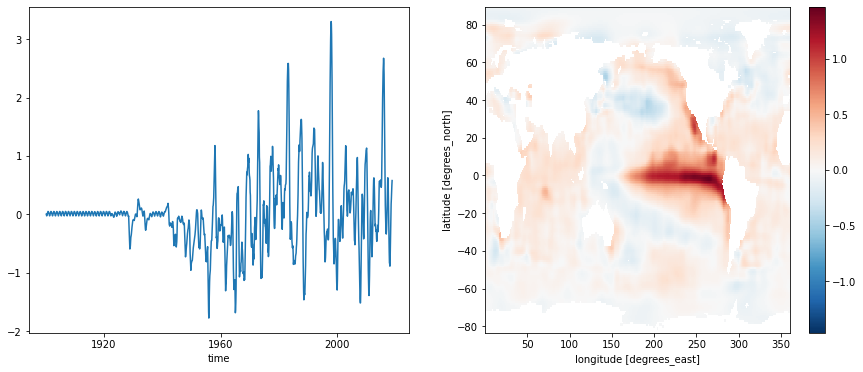

In [273]:
nino3, pattern = enso(ds_en)

<xarray.DataArray (lat: 173, lon: 360)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.09564774, -0.0960596 , -0.09616395, ..., -0.09506805,
        -0.09528677, -0.09547241],
       [-0.08322897, -0.08338308, -0.08341793, ..., -0.08296992,
        -0.08306364, -0.08315314],
       [-0.06634416, -0.06637569, -0.06637567, ..., -0.06627235,
        -0.06630639, -0.06633076]])
Coordinates:
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0


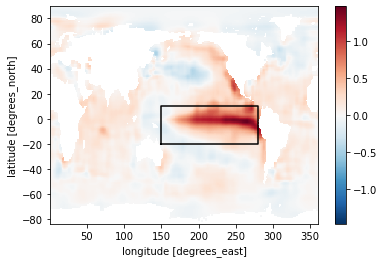

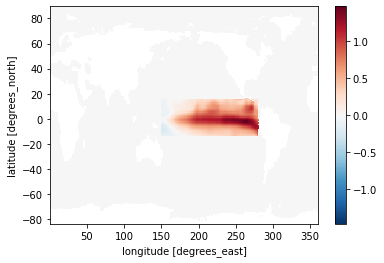

In [247]:
# Isolate pattern
fig, ax = plt.subplots(1,1)
pattern.plot(ax=ax)
lon1 = 150
lon2 = 280
lat1 = -20
lat2 = 10
ax.plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
ilon1 = int(lon1 / 1.)
ilon2 = int(lon2 / 1.)
ilat1 = int((lat1 + 90) / 1.)
ilat2 = int((lat2 + 90) / 1.)
pattern_sel = pattern * 0
pattern_sel[ilat1:ilat2,ilon1:ilon2] = pattern[ilat1:ilat2,ilon1:ilon2]
fig, ax = plt.subplots(1,1)
pattern_sel.plot(ax=ax)
pattern_sel.fillna(0).to_netcdf('nino3_pattern.nc')

## Compute PDO

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'eofs' (lat: 41, lon: 141)>
array([[ 0.01110407,  0.04399801,  0.0699271 , ...,         nan,
                nan,         nan],
       [-0.016348  ,  0.01470532,  0.04010928, ...,         nan,
                nan,         nan],
       [-0.02860058, -0.00739588,  0.0100979 , ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    mode     int64 0
  * lat      (lat) float32 20.0 21.0 22.0 23.0 24.0 ... 56.0 57.0 58.0 59.0 60.0
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 257.0 258.0 259.0 260.0
Attributes:
    long_name:  correlation_between_pcs_and_None


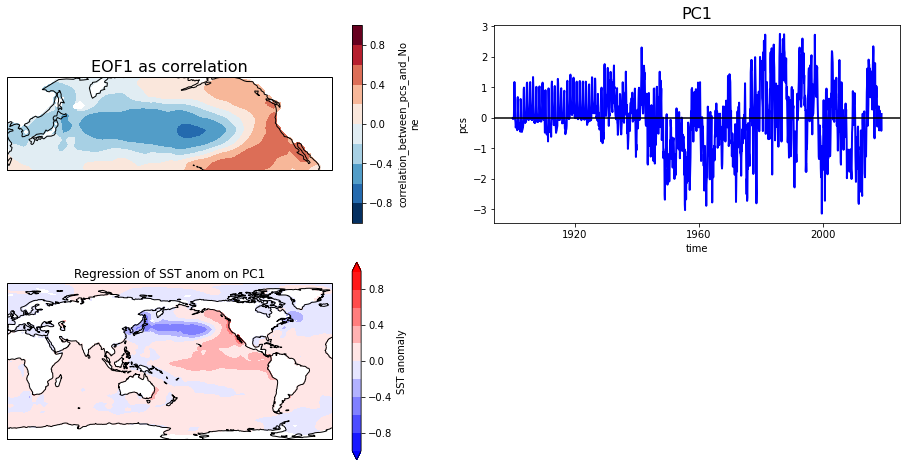

In [251]:
pdo_index,pdo_pattern,pdo_reg = pdo(ds_en,plot=True)

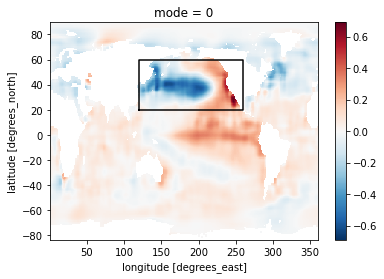

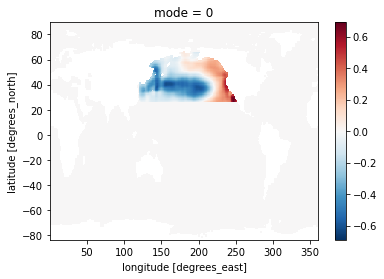

In [257]:
# Isolate pattern
fig, ax = plt.subplots(1,1)
pdo_reg.plot(ax=ax)
lon1 = 120
lon2 = 260
lat1 = 20
lat2 = 60
ax.plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
ilon1 = int(lon1 / 1.)
ilon2 = int(lon2 / 1.)
ilat1 = int((lat1 + 90) / 1.)
ilat2 = int((lat2 + 90) / 1.)
pattern_sel = pdo_reg * 0
pattern_sel[ilat1:ilat2,ilon1:ilon2] = pdo_reg[ilat1:ilat2,ilon1:ilon2]
fig, ax = plt.subplots(1,1)
pattern_sel.plot(ax=ax)
pattern_sel.fillna(0).to_netcdf('pdo_pattern1.nc')

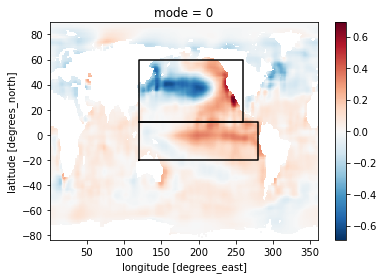

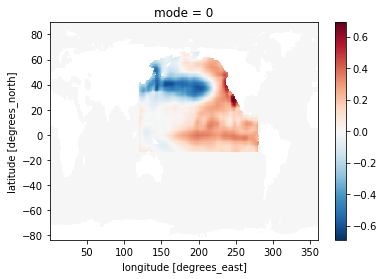

In [262]:
# Isolate pattern
fig, ax = plt.subplots(1,1)
pdo_reg.plot(ax=ax)
lon1 = 120
lon2 = 260
lat1 = 10
lat2 = 60
ax.plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
ilon1 = int(lon1 / 1.)
ilon2 = int(lon2 / 1.)
ilat1 = int((lat1 + 90) / 1.)
ilat2 = int((lat2 + 90) / 1.)
pattern_sel = pdo_reg * 0
pattern_sel[ilat1:ilat2,ilon1:ilon2] = pdo_reg[ilat1:ilat2,ilon1:ilon2]

lon1 = 120
lon2 = 280
lat1 = -20
lat2 = 10
ax.plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
ilon1 = int(lon1 / 1.)
ilon2 = int(lon2 / 1.)
ilat1 = int((lat1 + 90) / 1.)
ilat2 = int((lat2 + 90) / 1.)
pattern_sel[ilat1:ilat2,ilon1:ilon2] = pdo_reg[ilat1:ilat2,ilon1:ilon2]


fig, ax = plt.subplots(1,1)
pattern_sel.plot(ax=ax)
pattern_sel.fillna(0).to_netcdf('pdo_pattern2.nc')

## Compute AMO

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'eofs' (lat: 71, lon: 106)>
array([[ 0.05224005,  0.0476559 ,  0.04789667, ...,         nan,
                nan,         nan],
       [        nan,  0.04434302,  0.02990376, ...,         nan,
                nan,         nan],
       [        nan,  0.01608003, -0.01350232, ...,         nan,
                nan,         nan],
       ...,
       [-0.07535364, -0.06840673, -0.06067931, ..., -0.17603879,
        -0.19102077, -0.2031056 ],
       [-0.02849864, -0.02195156, -0.01467052, ..., -0.14169525,
        -0.15551712, -0.16708909],
       [ 0.02419095,  0.03014105,  0.03679864, ..., -0.10698976,
        -0.11973029, -0.13072863]], dtype=float32)
Coordinates:
    mode     int64 0
  * lat      (lat) float32 10.0 11.0 12.0 13.0 14.0 ... 76.0 77.0 78.0 79.0 80.0
  * lon      (lon) float32 -85.0 -84.0 -83.0 -82.0 -81.0 ... 17.0 18.0 19.0 20.0
Attributes:
    long_name:  correlation_between_pcs_and_sst_det


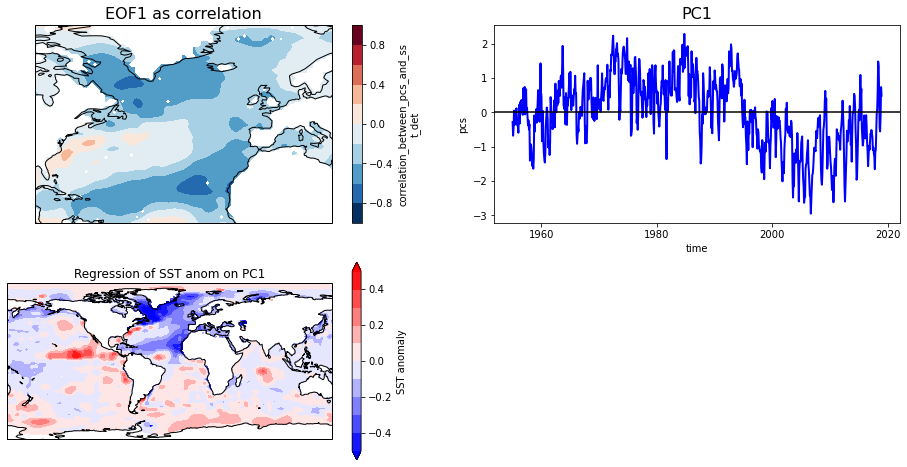

In [274]:
ds_180 = shift_lon(ds_en,shift360=True)
amo_index, amo_pattern, amo_reg = amo(ds_180,plot=True,method='eof')
#amo_index, amo_pattern = amo(ds_180,plot=True,method='enfield')

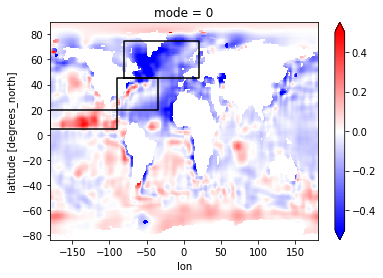

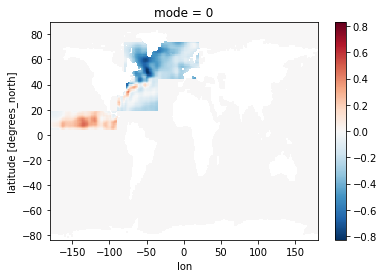

In [297]:
# Isolate pattern
fig, ax = plt.subplots(1,1)
amo_reg.plot(ax=ax,vmin=-0.5,vmax=0.5,cmap=plt.cm.bwr)

# Isolate subpolar gyre
lon1 = -80
lon2 = 20
lat1 = 45
lat2 = 75
ax.plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
ilon1 = int((lon1 + 180) / 1.)
ilon2 = int((lon2 + 180) / 1.)
ilat1 = int((lat1 + 83) / 1.)
ilat2 = int((lat2 + 83) / 1.)
pattern_sel = amo_reg * 0
pattern_sel[ilat1:ilat2,ilon1:ilon2] = amo_reg[ilat1:ilat2,ilon1:ilon2]
pattern_sel.fillna(0).to_netcdf('amo_pattern1.nc')

# Isolate Gulf Stream
lon1 = -90
lon2 = -35
lat1 = 20
lat2 = 45
ax.plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
ilon1 = int((lon1 + 180) / 1.)
ilon2 = int((lon2 + 180) / 1.)
ilat1 = int((lat1 + 83) / 1.)
ilat2 = int((lat2 + 83) / 1.)
pattern_sel[ilat1:ilat2,ilon1:ilon2] = amo_reg[ilat1:ilat2,ilon1:ilon2]
pattern_sel.fillna(0).to_netcdf('amo_pattern2.nc')

# Isolate east Pacific
lon1 = -180
lon2 = -90
lat1 = 5
lat2 = 20
ax.plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
ilon1 = int((lon1 + 180) / 1.)
ilon2 = int((lon2 + 180) / 1.)
ilat1 = int((lat1 + 83) / 1.)
ilat2 = int((lat2 + 83) / 1.)
pattern_sel[ilat1:ilat2,ilon1:ilon2] = amo_reg[ilat1:ilat2,ilon1:ilon2]
pattern_sel.fillna(0).to_netcdf('amo_pattern3.nc')

fig, ax = plt.subplots(1,1)
pattern_sel.plot(ax=ax)